In [2]:
targets = [i for i in range(10) for _ in range(4) for _ in range(3)]
print(targets)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


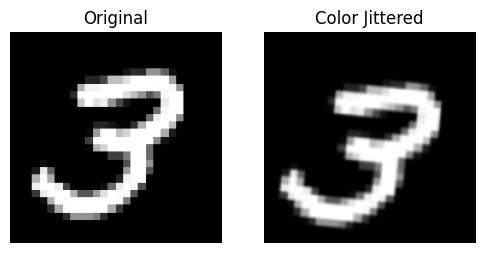

In [177]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter

def elastic_transform(image, alpha=34, sigma=4):
    """
    Apply differentiable elastic distortion to an image.
    
    Args:
    - image (torch.Tensor): Input image tensor of shape (1, H, W).
    - alpha (float): Scaling factor for the distortion.
    - sigma (float): Standard deviation for Gaussian filter.
    
    Returns:
    - torch.Tensor: Distorted image with the same shape as input.
    """
    # Ensure the image is on the correct device
    device = image.device
    B, H, W = image.shape

    # Generate random displacement fields
    dx = torch.randn(B, H, W, device=device)
    dy = torch.randn(B, H, W, device=device)
    
    # Apply Gaussian filter for smoothness
    dx = torch.tensor(gaussian_filter(dx.cpu().numpy(), sigma), device=device)
    dy = torch.tensor(gaussian_filter(dy.cpu().numpy(), sigma), device=device)
    
    # Scale displacement fields
    dx *= alpha
    dy *= alpha
    
    # Create mesh grid for pixel indices
    x, y = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
    x = x.unsqueeze(0).float()
    y = y.unsqueeze(0).float()
    
    # Add displacements
    x_displaced = x + dx
    y_displaced = y + dy
    
    # Normalize coordinates for grid_sample
    x_displaced = 2 * (x_displaced / (H - 1)) - 1
    y_displaced = 2 * (y_displaced / (W - 1)) - 1
    grid = torch.stack((y_displaced, x_displaced), dim=-1)
    
    # Apply grid_sample for bilinear interpolation
    distorted_image = F.grid_sample(image.unsqueeze(0), grid, align_corners=True)
    
    return distorted_image.squeeze(0)

import torch
import torch.nn.functional as F

def differentiable_rotate_translate_blur(image, angle_range=5, translate_range=2, blur_sigma=1):
    """
    Apply differentiable rotation, translation, and Gaussian blur to an image.
    
    Args:
    - image (torch.Tensor): Input image tensor of shape (1, H, W).
    - angle_range (float): Maximum angle for random rotation in degrees.
    - translate_range (float): Maximum translation in pixels for x and y directions.
    - blur_sigma (float): Standard deviation for Gaussian blur kernel.
    
    Returns:
    - torch.Tensor: Augmented image with the same shape as input.
    """
    device = image.device
    B, H, W = image.shape
    
    # Rotation
    angle = (torch.rand(1) * 2 - 1) * angle_range  # Random angle in range [-angle_range, angle_range]
    theta = torch.tensor([
        [torch.cos(torch.deg2rad(angle)), -torch.sin(torch.deg2rad(angle)), 0],
        [torch.sin(torch.deg2rad(angle)), torch.cos(torch.deg2rad(angle)), 0]
    ], device=device).unsqueeze(0)
    
    # Translation
    translate_x = (torch.rand(1) * 2 - 1) * translate_range
    translate_y = (torch.rand(1) * 2 - 1) * translate_range
    theta[0, 0, 2] = translate_x / (W / 2)  # Normalize for affine grid
    theta[0, 1, 2] = translate_y / (H / 2)  # Normalize for affine grid
    
    # Apply affine transformation (rotation + translation)
    grid = F.affine_grid(theta, image.unsqueeze(0).size(), align_corners=True)
    transformed_image = F.grid_sample(image.unsqueeze(0), grid, align_corners=True)
    
    # Gaussian Blur
    kernel_size = int(2 * 3 * blur_sigma + 1)  # Choose kernel size based on sigma
    x = torch.arange(kernel_size, dtype=torch.float32, device=device) - (kernel_size - 1) / 2
    gauss_kernel = torch.exp(-0.5 * (x / blur_sigma) ** 2)
    gauss_kernel = gauss_kernel / gauss_kernel.sum()
    
    # Create 2D Gaussian kernel from 1D kernels
    gauss_kernel_2d = gauss_kernel[:, None] @ gauss_kernel[None, :]
    gauss_kernel_2d = gauss_kernel_2d.expand(1, 1, kernel_size, kernel_size)
    
    # Apply Gaussian blur using convolution
    blurred_image = F.conv2d(transformed_image, gauss_kernel_2d, padding=kernel_size // 2)
    
    return blurred_image.squeeze(0)

# Load image
def load_image(path):
    image = Image.open(path).convert('L')  # Convert to grayscale
    transform = transforms.ToTensor()      # Convert to tensor with shape (1, H, W) and normalize to [0, 1]
    return transform(image)

# Main function
def main(image_path):
    x = load_image(image_path)
    x_jittered = differentiable_rotate_translate_blur(x, 10, 15)

    # Plot original and color-jittered images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(x.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Color Jittered")
    plt.imshow(x_jittered.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

# Example usage
img_path = r"D:\datasets\mnist3.png"
main(img_path)


In [13]:
!pip install scipy

  Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl (44.5 MB)
